In [147]:
# Importando todas bibliotecas necessárias

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import psycopg2
from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix

# Fazendo a conexão com o banco de dados

In [3]:
conn = psycopg2.connect("dbname='warehouse' user='admin' host='datawarehouse' password='admin123'")
cur = conn.cursor()
# conn.autocommit = True

## Pegando no banco de dados quais os anos dos modelos dos veículos na base para categorizar em veículos novos (50% mais novos) e antigos.

In [4]:
cur.execute("SELECT DISTINCT EXTRACT(YEAR FROM data_compra) as ano FROM veiculo ORDER BY ano ASC")
anos_veiculos = list(map(lambda v: int(v[0]), cur.fetchall()))

indice_metade = int(len(anos_veiculos) / 2)
anos_veiculos_novos = anos_veiculos[indice_metade:]
anos_veiculos_antigos = anos_veiculos[:indice_metade]

print('Anos dos veículos: {}'.format(anos_veiculos))
print('Anos de veículos novos: {}'.format(anos_veiculos_novos))
print('Anos de veículos antigos: {}'.format(anos_veiculos_antigos))

Anos dos veículos: [2013, 2014, 2015, 2016, 2017, 2018]
Anos de veículos novos: [2016, 2017, 2018]
Anos de veículos antigos: [2013, 2014, 2015]


## Buscando todos os sinistros

In [5]:
rows = []
columns = []

# Como o select retornará MUITOS dados, vamos pegar em batches.
with conn.cursor(name='large') as cursor:
    cursor.itersize = 20000

    query = """SELECT
                an.ano,
                EXTRACT(YEAR FROM cl.data_nasc) AS ano_cliente,
                EXTRACT(YEAR FROM ve.data_compra) AS ano_veiculo,
                cl.cliente_id AS id_cliente,
                cl.regiao AS regiao_cliente,
                cl.estado AS estado_cliente,
                cl.cidade AS cidade_cliente,
                cl.sexo AS sexo_cliente,
                ve.cor AS cor_veiculo,
                ve.valor_compra AS valor_veiculo,
                ve.nome_montadora AS montadora_veiculo,
                ve.nome_modelo AS modelo_veiculo,
                ve.pais_origem_montadora AS pais_montadora_veiculo
            FROM sinistro si
            INNER JOIN cliente cl ON si.cliente_id = cl.cliente_id
            INNER JOIN veiculo ve ON si.veiculo_id = ve.veiculo_id
            INNER JOIN ano an ON si.ano_id = an.ano_id;"""
    cursor.execute(query)
    for row in cursor:
        rows.append(row)
        
    for col in cursor.description:
        columns.append(col[0])
    
print('{} linhas recuperadas'.format(len(rows)))

819692 linhas recuperadas


In [6]:
df = pd.DataFrame(rows, columns=columns)
df

,ano,ano_cliente,ano_veiculo,id_cliente,regiao_cliente,estado_cliente,cidade_cliente,sexo_cliente,cor_veiculo,valor_veiculo,montadora_veiculo,modelo_veiculo,pais_montadora_veiculo
0,2018,1988.0,2015.0,1,sudeste,SP,campinas,F,preto,53028.0,fiat,uno,Italia
1,2017,1980.0,2016.0,4,nordeste,PE,belo jardim,M,azul,49019.0,volkswagen,gol,Alemanha
2,2015,1980.0,2013.0,4,nordeste,PE,belo jardim,M,branco,82015.0,volkswagen,polo,Alemanha
3,2018,1980.0,2013.0,4,nordeste,PE,belo jardim,M,branco,82015.0,volkswagen,polo,Alemanha
4,2013,1962.0,2013.0,5,sul,SC,palmitos,M,preto,66006.0,honda,city,Japao
...,...,...,...,...,...,...,...,...,...,...,...,...,...
819687,2017,1986.0,2015.0,999997,nordeste,PE,petrolina,F,vermelho,83021.0,honda,fit,Japao
819688,2013,1986.0,2013.0,999997,nordeste,PE,petrolina,F,prata,66030.0,honda,city,Japao
819689,2016,1986.0,2013.0,999997,nordeste,PE,petrolina,F,prata,66030.0,honda,city,Japao
819690,2018,1986.0,2013.0,999997,nordeste,PE,petrolina,F,prata,66030.0,honda,city,Japao


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 819692 entries, 0 to 819691
Data columns (total 13 columns):
ano                       819692 non-null int64
ano_cliente               819692 non-null float64
ano_veiculo               819692 non-null float64
id_cliente                819692 non-null int64
regiao_cliente            819692 non-null object
estado_cliente            819692 non-null object
cidade_cliente            819692 non-null object
sexo_cliente              819692 non-null object
cor_veiculo               819692 non-null object
valor_veiculo             819692 non-null float64
montadora_veiculo         819692 non-null object
modelo_veiculo            819692 non-null object
pais_montadora_veiculo    819692 non-null object
dtypes: float64(3), int64(2), object(8)
memory usage: 81.3+ MB


# Fazendo a limpeza no dataframe, convertendo tipos, etc

In [8]:
df[['ano_cliente', 'ano_veiculo', 'ano']] = df[['ano_cliente', 'ano_veiculo','ano']].astype(int)

In [9]:
df[['ano_cliente', 'ano_veiculo', 'valor_veiculo', 'ano']].describe()

,ano_cliente,ano_veiculo,valor_veiculo,ano
count,819692.000000,819692.000000,819692.000000,819692.000000
mean,1975.868998,2014.688570,78734.241962,2016.346564
std,16.144379,1.693449,43856.754575,1.555442
min,1940.000000,2013.000000,41000.000000,2013.000000
25%,1968.000000,2013.000000,48007.000000,2015.000000
50%,1979.000000,2014.000000,69045.000000,2017.000000
75%,1988.000000,2016.000000,86044.000000,2018.000000
max,1999.000000,2018.000000,318049.000000,2018.000000


# Verificando correlação

In [10]:
df_grouped = df.groupby(['ano', 'ano_cliente', 'ano_veiculo'])['valor_veiculo'].sum().reset_index()
# df_grouped.rename(columns={ df_grouped.columns[4]: "quantidade_sinistros" }, inplace = True)
df_grouped

,ano,ano_cliente,ano_veiculo,valor_veiculo
0,2013,1940,2013,57875183.0
1,2013,1941,2013,57638438.0
2,2013,1942,2013,58554154.0
3,2013,1943,2013,52773445.0
4,2013,1944,2013,57584634.0
...,...,...,...,...
1255,2018,1999,2014,40782249.0
1256,2018,1999,2015,40002463.0
1257,2018,1999,2016,64244302.0
1258,2018,1999,2017,93231679.0


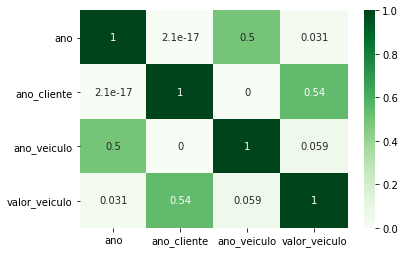

In [11]:
cor = df_grouped.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Greens)
plt.show()

In [12]:
df_grouped2 = df.groupby(['modelo_veiculo', 'ano_cliente', 'ano_veiculo', 'valor_veiculo']).size().reset_index()
df_grouped2.rename(columns={ df_grouped2.columns[4]: "quantidade_sinistros" }, inplace = True)
df_grouped2

,modelo_veiculo,ano_cliente,ano_veiculo,valor_veiculo,quantidade_sinistros
0,argo,1940,2013,76000.0,2
1,argo,1940,2013,76001.0,2
2,argo,1940,2013,76003.0,3
3,argo,1940,2013,76004.0,4
4,argo,1940,2013,76005.0,1
...,...,...,...,...,...
259305,wrv,1999,2018,74038.0,1
259306,wrv,1999,2018,74040.0,1
259307,wrv,1999,2018,74041.0,1
259308,wrv,1999,2018,74044.0,1


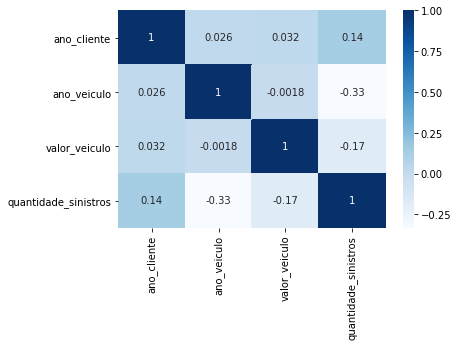

In [13]:
cor = df_grouped2.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
plt.show()

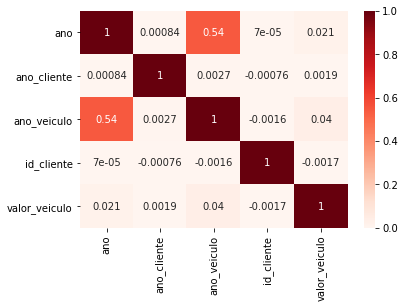

In [14]:
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

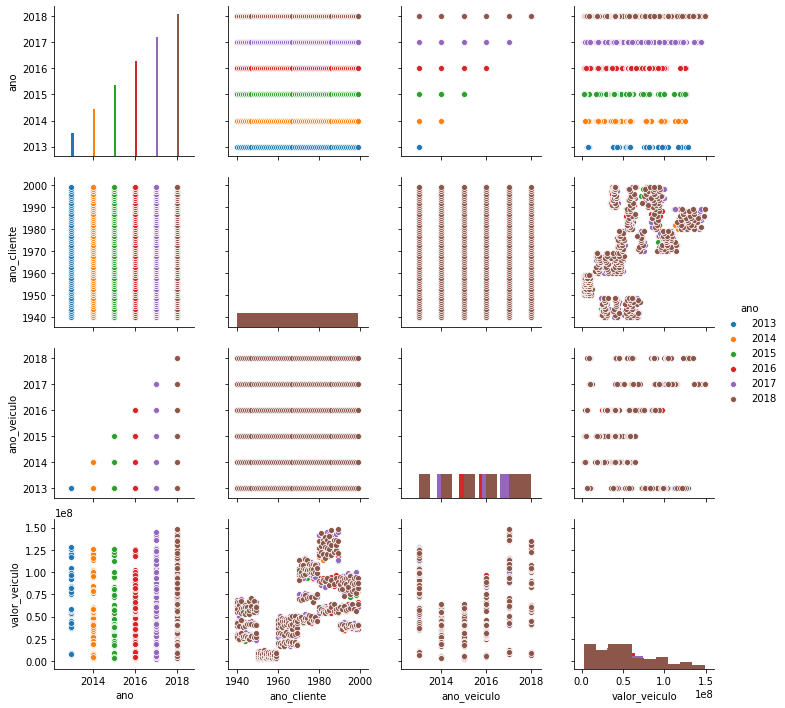

In [15]:
sns.pairplot(df_grouped, hue='ano', diag_kind='hist')

## As correlações estão claramente fracas, mas precisamos agrupar os dados em clusters pra fazer sentidos. 

Por exemplo, podemos dividir os clientes em grupos de motoristas experientes ou não, ou os modelos de veículos de antigos e novos

In [16]:
kmeans = KMeans(n_clusters=2).fit(df_grouped[['ano_veiculo']])
df_grouped.loc[:,'grupo_ano_veiculo'] = kmeans.labels_
centroids = kmeans.cluster_centers_
print('Centroídes: {}'.format(centroids))

kmeans = KMeans(n_clusters=2).fit(df_grouped[['ano_cliente']])
df_grouped.loc[:,'grupo_ano_cliente'] = kmeans.labels_
centroids = kmeans.cluster_centers_
print('Centroídes: {}'.format(centroids))
df_grouped

Centroídes: [[2016.        ]
 [2013.45454545]]
Centroídes: [[1985.]
 [1955.]]


,ano,ano_cliente,ano_veiculo,valor_veiculo,grupo_ano_veiculo,grupo_ano_cliente
0,2013,1940,2013,57875183.0,1,1
1,2013,1941,2013,57638438.0,1,1
2,2013,1942,2013,58554154.0,1,1
3,2013,1943,2013,52773445.0,1,1
4,2013,1944,2013,57584634.0,1,1
...,...,...,...,...,...,...
1255,2018,1999,2014,40782249.0,1,0
1256,2018,1999,2015,40002463.0,0,0
1257,2018,1999,2016,64244302.0,0,0
1258,2018,1999,2017,93231679.0,0,0


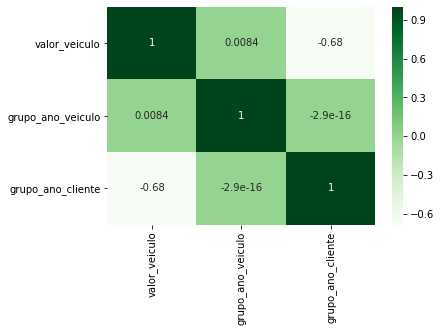

In [17]:
cor = df_grouped[['valor_veiculo', 'grupo_ano_veiculo', 'grupo_ano_cliente']].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Greens)
plt.show()

Mesmo assim, a correlação é baixa.

# Vamos também clusterizar a quantidade de sinistros para verificar se existe uma correlação com as demais colunas

In [130]:
kmeans = KMeans(n_clusters=4).fit(df_grouped2[['quantidade_sinistros']])
df_grouped2.loc[:,'grupo_quantidade_sinistros'] = kmeans.labels_
centroids = kmeans.cluster_centers_
print('Centroídes: {}'.format(centroids))
df_grouped2

Centroídes: [[ 7.79756228]
 [ 1.37579171]
 [16.83196721]
 [ 3.72207711]]


,modelo_veiculo,ano_cliente,ano_veiculo,valor_veiculo,quantidade_sinistros,grupo_quantidade_sinistros
0,argo,1940,2013,76000.0,2,1
1,argo,1940,2013,76001.0,2,1
2,argo,1940,2013,76003.0,3,3
3,argo,1940,2013,76004.0,4,3
4,argo,1940,2013,76005.0,1,1
...,...,...,...,...,...,...
259305,wrv,1999,2018,74038.0,1,1
259306,wrv,1999,2018,74040.0,1,1
259307,wrv,1999,2018,74041.0,1,1
259308,wrv,1999,2018,74044.0,1,1


In [137]:
df2 = df_grouped2[['grupo_quantidade_sinistros', 'ano_veiculo', 'ano_cliente', 'valor_veiculo']]
df_grouped2.groupby(['grupo_quantidade_sinistros'])['quantidade_sinistros'].size()

grupo_quantidade_sinistros
0     31669
1    151097
2      6100
3     70444
Name: quantidade_sinistros, dtype: int64

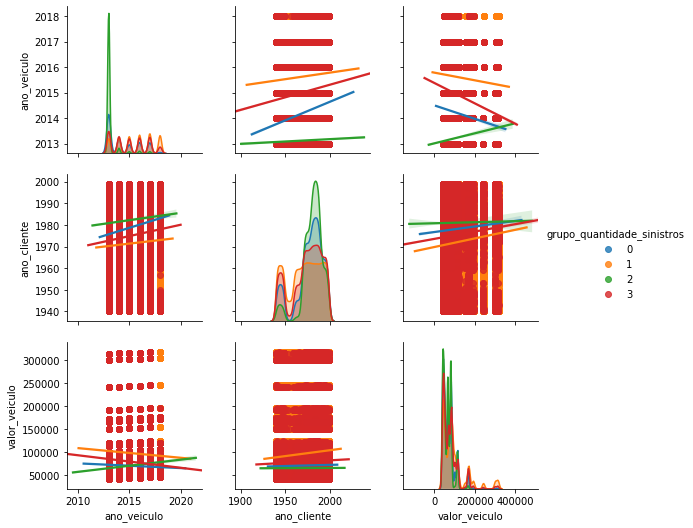

In [135]:
sns.pairplot(df2, vars=['ano_veiculo', 'ano_cliente', 'valor_veiculo'], hue='grupo_quantidade_sinistros', kind='reg')

In [ ]:
# v = df.drop('ano', axis=1).columns
# sns.pairplot(df, vars=v, hue='ano', diag_kind='hist')

# ---------------------------------
# Predizendo sinistros

A partir dos sinistros que ocorreram no último ano, vamos criar uma coluna no df pra pegar todos os clientes e modelos que tiveram sinistro no último ano e os que não tiveram

In [113]:
df3 = df.copy()
# df3.groupby(df3.columns).count().reset_index()
qtd_sinistros = df3.groupby(['id_cliente']).size()
classifiers = []

ultimo_ano = df.ano.max()
anos = df3['ano']

df3['quantidade_sinistros'] = df3.apply(lambda row: qtd_sinistros[row.id_cliente], axis=1)
df3 = df3.drop('ano', axis=1)
df3 = df3.drop_duplicates()

df3['sinistro_recente'] = df3.apply(lambda row: anos.at[row.name] == ultimo_ano, axis=1)
df3

,ano_cliente,ano_veiculo,id_cliente,regiao_cliente,estado_cliente,cidade_cliente,sexo_cliente,cor_veiculo,valor_veiculo,montadora_veiculo,modelo_veiculo,pais_montadora_veiculo,quantidade_sinistros,sinistro_recente
0,1988,2015,1,sudeste,SP,campinas,F,preto,53028.0,fiat,uno,Italia,1,True
1,1980,2016,4,nordeste,PE,belo jardim,M,azul,49019.0,volkswagen,gol,Alemanha,3,False
2,1980,2013,4,nordeste,PE,belo jardim,M,branco,82015.0,volkswagen,polo,Alemanha,3,False
4,1962,2013,5,sul,SC,palmitos,M,preto,66006.0,honda,city,Japao,1,False
5,1982,2017,9,norte,AM,barcelos,M,verde,170035.0,volkswagen,passat,Alemanha,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819685,1999,2013,999994,centro-oeste,MT,villa rica,M,preto,82049.0,volkswagen,polo,Alemanha,1,False
819686,1976,2018,999995,sul,RS,cachoeirinha,M,azul,48027.0,chevrolet,onix plus,EUA,1,True
819687,1986,2015,999997,nordeste,PE,petrolina,F,vermelho,83021.0,honda,fit,Japao,4,False
819688,1986,2013,999997,nordeste,PE,petrolina,F,prata,66030.0,honda,city,Japao,4,False


In [114]:
# Criando encoder pra colunas de string
d = defaultdict(LabelEncoder)
df3 = df3.apply(lambda x: d[x.name].fit_transform(x))

X = df3.drop(['sinistro_recente', 'id_cliente'], axis=1)
y = df3['sinistro_recente']

X

,ano_cliente,ano_veiculo,regiao_cliente,estado_cliente,cidade_cliente,sexo_cliente,cor_veiculo,valor_veiculo,montadora_veiculo,modelo_veiculo,pais_montadora_veiculo,quantidade_sinistros
0,48,2,3,9,11,0,4,628,1,26,2,0
1,40,3,1,6,5,1,0,419,5,12,0,2
2,40,0,1,6,5,1,1,1865,5,21,0,2
4,22,0,4,8,33,1,4,1056,3,3,3,0
5,42,4,2,0,2,1,5,3984,5,20,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
819685,59,0,0,4,51,1,4,1899,5,21,0,0
819686,36,5,4,7,9,1,0,377,0,19,1,0
819687,46,2,1,6,37,0,6,1921,3,9,3,3
819688,46,0,1,6,37,0,3,1080,3,3,3,3


In [115]:
# Dividindo os datasets pra treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)


# Escalando os dados pra obter melhores resultados
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [116]:
# Usando rede neural pra classificar a probabilidade de um cliente sofrer um sinistro ou não no último ano.
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=2000)
mlp.fit(X_train, y_train.values.ravel())

predictions = mlp.predict(X_test)

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

classifiers.append(mlp)

[[86129  4891]
 [19603 15351]]
              precision    recall  f1-score   support

           0       0.81      0.95      0.88     91020
           1       0.76      0.44      0.56     34954

    accuracy                           0.81    125974
   macro avg       0.79      0.69      0.72    125974
weighted avg       0.80      0.81      0.79    125974



In [117]:
# Usando ADABoost
from sklearn.ensemble import AdaBoostClassifier

classifier = AdaBoostClassifier(n_estimators=100, random_state=1)
classifier.fit(X_train, y_train.values.ravel())

predictions = classifier.predict(X_test)

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

classifiers.append(classifier)

[[84347  6673]
 [17806 17148]]
              precision    recall  f1-score   support

           0       0.83      0.93      0.87     91020
           1       0.72      0.49      0.58     34954

    accuracy                           0.81    125974
   macro avg       0.77      0.71      0.73    125974
weighted avg       0.80      0.81      0.79    125974



In [118]:
# Usando vetor de suporte / Modelo gradiente estocástico
from sklearn.linear_model import SGDClassifier

classifier = SGDClassifier(max_iter=1000, tol=1e-3)
classifier.fit(X_train, y_train.values.ravel())

predictions = classifier.predict(X_test)

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

classifiers.append(classifier)

[[80686 10334]
 [15814 19140]]
              precision    recall  f1-score   support

           0       0.84      0.89      0.86     91020
           1       0.65      0.55      0.59     34954

    accuracy                           0.79    125974
   macro avg       0.74      0.72      0.73    125974
weighted avg       0.78      0.79      0.79    125974



In [119]:
# Usando random forest
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
classifier.fit(X_train, y_train.values.ravel())

predictions = classifier.predict(X_test)

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

classifiers.append(classifier)

[[91020     0]
 [24523 10431]]
              precision    recall  f1-score   support

           0       0.79      1.00      0.88     91020
           1       1.00      0.30      0.46     34954

    accuracy                           0.81    125974
   macro avg       0.89      0.65      0.67    125974
weighted avg       0.85      0.81      0.76    125974



### Será que os membros do grupo seriam clientes propícios a ter um sinistro? 🤔🤔🤔

TODO

In [120]:
X.columns

Index(['ano_cliente', 'ano_veiculo', 'regiao_cliente', 'estado_cliente',
       'cidade_cliente', 'sexo_cliente', 'cor_veiculo', 'valor_veiculo',
       'montadora_veiculo', 'modelo_veiculo', 'pais_montadora_veiculo',
       'quantidade_sinistros'],
      dtype='object')

In [144]:
# colunas = list(filter(lambda c: c not in ['sinistro_recente', 'id_cliente'], df3.columns))

viegas = (1997, 2013, 'Sudeste', 'MG', 'Betim', 'M', 'branco', 22000.0, 'fiat', 'palio', 'Italia', 0)
bruno = (1998, 2008, 'Sudeste', 'MG', 'Florestal', 'M', 'preto', 14000.0, 'fiat', 'palio', 'Italia', 0)
fake = (1985, 1990, 'Nordeste', 'PE', 'Recife', 'M', 'branco', 43900.0, 'honda', 'civic', 'Japão', 9)

pessoas = [viegas, bruno, fake]
df4 = pd.DataFrame(pessoas, columns=X.columns)
df4

,ano_cliente,ano_veiculo,regiao_cliente,estado_cliente,cidade_cliente,sexo_cliente,cor_veiculo,valor_veiculo,montadora_veiculo,modelo_veiculo,pais_montadora_veiculo,quantidade_sinistros
0,1997,2013,Sudeste,MG,Betim,M,branco,22000.0,fiat,palio,Italia,0
1,1998,2008,Sudeste,MG,Florestal,M,preto,14000.0,fiat,palio,Italia,0
2,1985,1990,Nordeste,PE,Recife,M,branco,43900.0,honda,civic,Japão,9


In [145]:
df4 = df4.apply(lambda x: d[x.name].fit_transform(x))
df4_test = scaler.transform(df4)

df4_test

array([[-2.16111297,  0.04254376, -1.08411432, -2.5434432 , -1.81537014,
        -3.31542266, -2.57034524, -1.22132242, -1.77050614, -1.5740241 ,
        -1.48146709, -0.76883213],
       [-2.09914597, -0.53097358, -1.08411432, -2.5434432 , -1.74550413,
        -3.31542266, -1.941976  , -1.22214619, -1.77050614, -1.5740241 ,
        -1.48146709, -0.76883213],
       [-2.22307998, -1.10449092, -1.82038714, -2.13740288, -1.67563812,
        -3.31542266, -2.57034524, -1.22049865, -1.14855741, -1.68587247,
        -0.65480383,  0.24614359]])

In [146]:
cs = [classifiers[0], classifiers[3]]

for c in cs:
    probs = c.predict_proba(df4_test)
    print(probs)
    for p in probs:
        print('{:.2f}%'.format(p[1] * 100))
    print('------------')

[[0.72089441 0.27910559]
 [0.82176136 0.17823864]
 [0.94881003 0.05118997]]
27.91%
17.82%
5.12%
------------
[[0.76963567 0.23036433]
 [0.76852464 0.23147536]
 [0.84046051 0.15953949]]
23.04%
23.15%
15.95%
------------
